In [1]:
import numpy as np 
import pandas as pd

In [2]:
weather = pd.read_csv('../datasets/nyc_weather_2018.csv', parse_dates=['date'])
fb = pd.read_csv('../datasets/fb.csv', index_col='date', parse_dates=True)

In [3]:
weather.head(2)

,date,datatype,station,attributes,value
0,2018-01-01,PRCP,GHCND:US1CTFR0039,",,N,",0.0
1,2018-01-01,PRCP,GHCND:US1NJBG0015,",,N,",0.0


In [4]:
fb.head(2)

,high,low,open,close,volume
date,,,,,
2018-01-02,181.580002,177.550003,177.679993,181.419998,18151900
2018-01-03,184.779999,181.330002,181.880005,184.669998,16886600


In [5]:
# calculate the z-score for volume column and find where its absolute
# value is more than 3 std away
fb.assign(
    volume_z_score = lambda x: x.volume.sub(
        x.volume.mean()
    ).div(x.volume.std()).abs()
).query('volume_z_score > 3')

,high,low,open,close,volume,volume_z_score
date,,,,,,
2018-03-19,177.169998,170.059998,177.009995,172.559998,88140100,3.154098
2018-03-20,170.199997,161.949997,167.470001,168.149994,129851800,5.329354
2018-03-21,173.399994,163.300003,164.800003,169.389999,106598800,4.116715
2018-03-26,161.100006,149.020004,160.820007,160.059998,126116600,5.134564
2018-07-26,180.130005,173.750000,174.889999,176.259995,169803700,7.412837


Find 5 days with the largest percentage change of the volume traded from the prior day. Use `rank(ascending=False)` and `pct_change()`

In [9]:
fb.assign(
    volume_pct_change = fb.volume.pct_change(),
    change_rank = fb.volume.pct_change().abs().rank(ascending=False)
    # same result: but access the column that we've just created
    #change_rank = lambda x: x.volume_pct_change.abs().rank(ascending=False)
).nsmallest(5, 'change_rank')

,high,low,open,close,volume,volume_pct_change,change_rank
date,,,,,,,
2018-01-12,181.479996,177.399994,178.059998,179.369995,77551300,7.087865,1.0
2018-03-19,177.169998,170.059998,177.009995,172.559998,88140100,2.611796,2.0
2018-07-26,180.130005,173.750000,174.889999,176.259995,169803700,1.880265,3.0
2018-09-21,167.250000,162.809998,166.639999,162.929993,45994800,1.428961,4.0
2018-03-26,161.100006,149.020004,160.820007,160.059998,126116600,1.352496,5.0


In [10]:
# slice the biggest pct_change
fb['2018-01-11':'2018-01-12']

,high,low,open,close,volume
date,,,,,
2018-01-11,188.399994,187.380005,188.399994,187.770004,9588600
2018-01-12,181.479996,177.399994,178.059998,179.369995,77551300


In [11]:
# check if any of prices high/low/open/close where bigger than $215 during this year
(fb > 215).any()
# low prices never were higher than $215

high       True
low       False
open       True
close      True
volume     True
dtype: bool

#### Binning

we might be interested in ranges of volume rather than the volume by itself, we can convert the numerical column into a categorical usind `pd.cut()`. It calls binning or **discretizing** (going from continious to descrete)

In [12]:
# check if in any of days the volume was the same
(fb.volume.value_counts() > 1).sum()

0

In [13]:
(fb.volume.value_counts() > 1).any()

False

In [14]:
%who

fb	 np	 pd	 weather	 


Equal intervals bins

`pd.cut`

In [15]:
binned = pd.cut(fb.volume, bins=3, labels=['low', 'medium', 'high'])
binned.value_counts()

low       241
medium      7
high        3
Name: volume, dtype: int64

In [20]:
# check high volume days
fb[binned == 'high'].sort_values('volume', ascending=False)

,high,low,open,close,volume
date,,,,,
2018-07-26,180.130005,173.750000,174.889999,176.259995,169803700
2018-03-20,170.199997,161.949997,167.470001,168.149994,129851800
2018-03-26,161.100006,149.020004,160.820007,160.059998,126116600


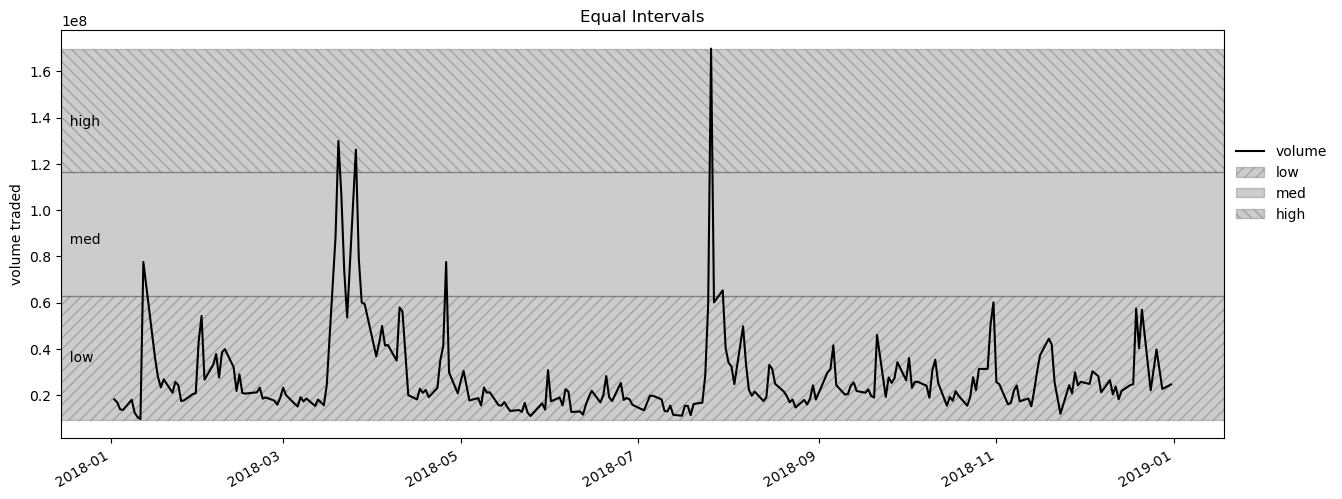

In [29]:

import matplotlib.pyplot as plt
#from matplotlib.patches import Ellipse
import seaborn as sns
ax = fb.plot(y='volume', figsize=(15, 6), color='black', title='Equal Intervals')

xlims = ax.get_xlim()

for bin_name, hatch, bounds in zip(
    ['low', 'med', 'high'],
    ['///', '', '\\\\\\'],
    pd.cut(fb['volume'], bins=3).unique().categories.values
):
    plt.axhspan(bounds.left, bounds.right, alpha=0.2, label=bin_name, hatch=hatch, color='black')
    plt.annotate(f'  {bin_name}', xy=(xlims[0], (bounds.left + bounds.right) / 2.1), ha='left')

ax.set(xlabel='', ylabel='volume traded')
plt.legend(bbox_to_anchor=(1, 0.75), frameon=False)
plt.show()

Q-Bins: equal number of observations in each bin

`pd.qcut`

In [26]:
qbinned = pd.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
qbinned.value_counts()

q1    63
q2    63
q4    63
q3    62
Name: volume, dtype: int64

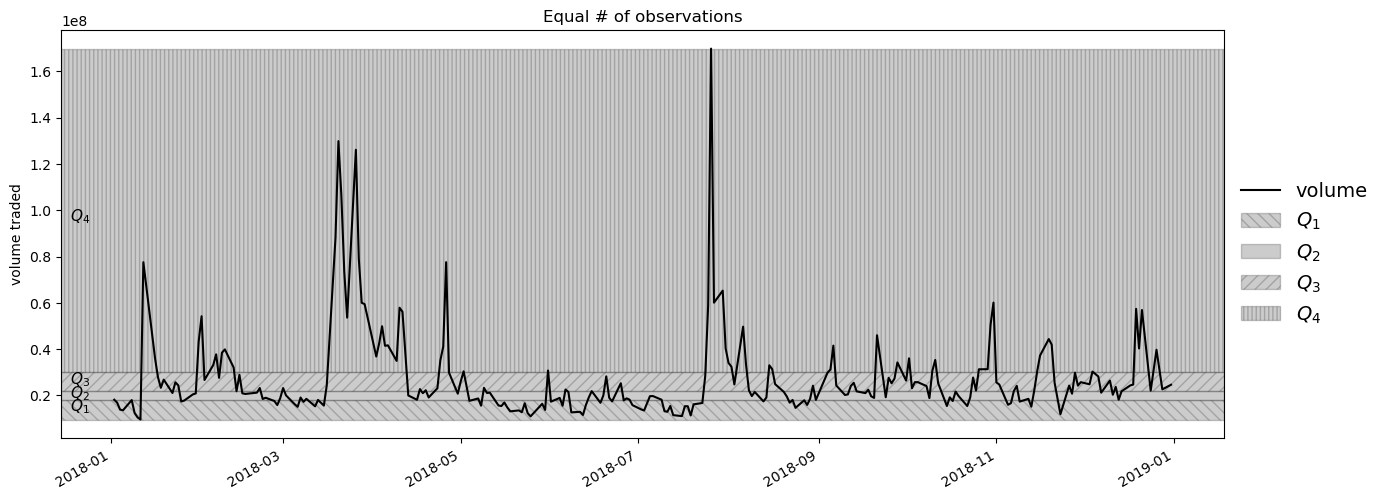

In [30]:
ax = fb.plot(y='volume', figsize=(15, 6), color='black', title='Equal # of observations')

xlims = ax.get_xlim()

for bin_name, hatch, bounds in zip(
    [r'$Q_1$', r'$Q_2$', r'$Q_3$', r'$Q_4$'],
    ['\\\\\\', '', '///', '||||'],
    pd.qcut(fb.volume, q=4).unique().categories.values
):
    plt.axhspan(bounds.left, bounds.right, alpha=0.2, label=bin_name, hatch=hatch, color='black')
    plt.annotate(f'  {bin_name}', xy=(xlims[0], (bounds.left + bounds.right) / 2.1), fontsize=11)

ax.set(xlabel='', ylabel='volume traded')
plt.legend(bbox_to_anchor=(1, 0.67), frameon=False, fontsize=14)
plt.show()

#### Thresholds

In [32]:
weather.head(2)

,date,datatype,station,attributes,value
0,2018-01-01,PRCP,GHCND:US1CTFR0039,",,N,",0.0
1,2018-01-01,PRCP,GHCND:US1NJBG0015,",,N,",0.0


In [66]:
# filter by station and save in wide format (pivot)
cp_weather = weather\
    .query('station == "GHCND:USW00094728"')\
    .pivot(index='date', columns='datatype', values='value')

In [35]:
cp_weather.head(2)

datatype,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT06,WT08
date,,,,,,,,,,,,,,,
2018-01-01,3.5,0.0,0.0,0.0,-7.1,-13.8,300.0,300.0,6.7,11.2,NaN,NaN,NaN,NaN,NaN
2018-01-02,3.6,0.0,0.0,0.0,-3.2,-10.5,260.0,250.0,7.2,12.5,NaN,NaN,NaN,NaN,NaN


`clip(lower, upper)` bounds. `clip` will assign values outside the boundaries

In [36]:
cp_weather.SNOW.value_counts()

0.0      354
249.0      1
10.0       1
3.0        1
23.0       1
13.0       1
112.0      1
81.0       1
208.0      1
5.0        1
140.0      1
163.0      1
Name: SNOW, dtype: int64

In [43]:
cp_weather.SNOW.clip(0, 1).value_counts()

0.0    354
1.0     11
Name: SNOW, dtype: int64

In [44]:
cp_weather.SNOW.clip(0, 6).value_counts() # everything that is 6 and higher is now 6.0

0.0    354
6.0      9
3.0      1
5.0      1
Name: SNOW, dtype: int64

#### Applying functions

In [45]:
cp_weather.head(2)

datatype,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT06,WT08
date,,,,,,,,,,,,,,,
2018-01-01,3.5,0.0,0.0,0.0,-7.1,-13.8,300.0,300.0,6.7,11.2,NaN,NaN,NaN,NaN,NaN
2018-01-02,3.6,0.0,0.0,0.0,-3.2,-10.5,260.0,250.0,7.2,12.5,NaN,NaN,NaN,NaN,NaN


In [68]:
# slice October 2018 TMAX, TMIN and PRCP
october = cp_weather.loc['2018-10', ['TMIN', 'TMAX', 'PRCP']]
october.head(2)

datatype,TMIN,TMAX,PRCP
date,,,
2018-10-01,17.2,24.4,0.0
2018-10-02,18.3,25.0,17.5


`apply` runs vectorized operarions on rows or columns at once

In [51]:
# calculate z-score for every column
october_z_score = october.apply(
    lambda x: x.sub(x.mean()).div(x.std())
)

In [52]:
october_z_score.head(2)

datatype,TMIN,TMAX,PRCP
date,,,
2018-10-01,1.065152,1.203293,-0.394438
2018-10-02,1.255418,1.307830,1.951865


In [55]:
october_z_score.describe()[1:].T

,mean,std,min,25%,50%,75%,max
datatype,,,,,,,
TMIN,-1.790682e-16,1.0,-1.339112,-0.751019,-0.474269,1.065152,1.843511
TMAX,1.951844e-16,1.0,-1.305582,-0.870013,-0.138258,1.011643,1.604016
PRCP,4.655774e-17,1.0,-0.394438,-0.394438,-0.394438,-0.240253,3.936167


Other functions: `applymap` if the function is not vectorized, `np.vectorize()` to vectorize our functions to use with `apply`. F.e. `len` is not vectorized.

In [58]:
fb.head(2)

,high,low,open,close,volume
date,,,,,
2018-01-02,181.580002,177.550003,177.679993,181.419998,18151900
2018-01-03,184.779999,181.330002,181.880005,184.669998,16886600


In [61]:
fb.applymap(lambda x: np.ceil(x)).head(2)

,high,low,open,close,volume
date,,,,,
2018-01-02,182.0,178.0,178.0,182.0,18151900.0
2018-01-03,185.0,182.0,182.0,185.0,16886600.0


In [56]:
fb.apply(lambda x: len(str(np.ceil(x))))

high      264
low       263
open      264
close     265
volume    321
dtype: int64

Count digits of the whole numbers using non-vectorized len

In [62]:
fb.applymap(lambda x: len(str(np.ceil(x)))).head(2)

,high,low,open,close,volume
date,,,,,
2018-01-02,5,5,5,5,10
2018-01-03,5,5,5,5,10


In [63]:
# or
fb.apply(np.vectorize(lambda x: len(str(np.ceil(x))))).head(2)

,high,low,open,close,volume
date,,,,,
2018-01-02,5,5,5,5,10
2018-01-03,5,5,5,5,10


### Window calculations

In [67]:
cp_weather.head(2)

datatype,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT06,WT08
date,,,,,,,,,,,,,,,
2018-01-01,3.5,0.0,0.0,0.0,-7.1,-13.8,300.0,300.0,6.7,11.2,NaN,NaN,NaN,NaN,NaN
2018-01-02,3.6,0.0,0.0,0.0,-3.2,-10.5,260.0,250.0,7.2,12.5,NaN,NaN,NaN,NaN,NaN


Calculate a total amount of rain fallen in 3-day window in October using `rolling` method.

In [69]:
october.head(2)

datatype,TMIN,TMAX,PRCP
date,,,
2018-10-01,17.2,24.4,0.0
2018-10-02,18.3,25.0,17.5


In [74]:
october.assign(
    rolling_PRCP = lambda x: x.PRCP.rolling('3D').sum()
).head(15)

datatype,TMIN,TMAX,PRCP,rolling_PRCP
date,,,,
2018-10-01,17.2,24.4,0.0,0.0
2018-10-02,18.3,25.0,17.5,17.5
2018-10-03,17.2,23.3,0.0,17.5
2018-10-04,16.1,24.4,1.0,18.5
2018-10-05,15.6,21.7,0.0,1.0
2018-10-06,17.2,20.0,0.0,1.0
2018-10-07,19.4,26.1,0.0,0.0
2018-10-08,17.8,23.3,0.0,0.0
2018-10-09,18.9,25.0,0.0,0.0


In [76]:
# apply rolling calculations to all column
october.rolling('3D').mean().head(10)

datatype,TMIN,TMAX,PRCP
date,,,
2018-10-01,17.200000,24.400000,0.000000
2018-10-02,17.750000,24.700000,8.750000
2018-10-03,17.566667,24.233333,5.833333
2018-10-04,17.200000,24.233333,6.166667
2018-10-05,16.300000,23.133333,0.333333
2018-10-06,16.300000,22.033333,0.333333
2018-10-07,17.400000,22.600000,0.000000
2018-10-08,18.133333,23.133333,0.000000
2018-10-09,18.700000,24.800000,0.000000


Difference between using a string and integer as a parameter for `rolling` method: 
- `rolling(n: integer)`: first `n-1` values are `NaN`
- `rolling('nD': string)`: calculates all values since the beginning rolling(1), rolling(2), rolling(n)

In [85]:
october.rolling(3).max().join(
    october, lsuffix='_r'
).head(3)

datatype,TMIN_r,TMAX_r,PRCP_r,TMIN,TMAX,PRCP
date,,,,,,
2018-10-01,NaN,NaN,NaN,17.2,24.4,0.0
2018-10-02,NaN,NaN,NaN,18.3,25.0,17.5
2018-10-03,18.3,25.0,17.5,17.2,23.3,0.0


In [87]:
october.rolling('3D').min().join(
    october, lsuffix='_r'
).head(3)

datatype,TMIN_r,TMAX_r,PRCP_r,TMIN,TMAX,PRCP
date,,,,,,
2018-10-01,17.2,24.4,0.0,17.2,24.4,0.0
2018-10-02,17.2,24.4,0.0,18.3,25.0,17.5
2018-10-03,17.2,23.3,0.0,17.2,23.3,0.0


Rolling and aggregating with `agg`: pass a dictionary: where the key is a column name and the value is an aggregation function.

In [91]:
october.rolling('3D').agg(
    {'TMIN':'min', 'TMAX': 'max', 'PRCP': 'mean'}
).join(
    october, lsuffix='_r'
).sort_index(axis=1).head() # sort_index to sort columns

datatype,PRCP,PRCP_r,TMAX,TMAX_r,TMIN,TMIN_r
date,,,,,,
2018-10-01,0.0,0.000000,24.4,24.4,17.2,17.2
2018-10-02,17.5,8.750000,25.0,25.0,18.3,17.2
2018-10-03,0.0,5.833333,23.3,25.0,17.2,17.2
2018-10-04,1.0,6.166667,24.4,25.0,16.1,16.1
2018-10-05,0.0,0.333333,21.7,24.4,15.6,15.6


### `rolling` vs `expanding`

- `rolling`: sliding window
- `expanding`: all data up to the point -> `cumulative value`

`expanding().sum()` equals to `cumsum()` but `expanding` gives us the possibility to use other `agg` functions as well

In [101]:
# expanding -> provide expanding window calculations
precip = october.PRCP
pd.DataFrame({'expanding': precip.expanding().sum(), 'cumsum': precip.cumsum()}).head(10)

,expanding,cumsum
date,,
2018-10-01,0.0,0.0
2018-10-02,17.5,17.5
2018-10-03,17.5,17.5
2018-10-04,18.5,18.5
2018-10-05,18.5,18.5
2018-10-06,18.5,18.5
2018-10-07,18.5,18.5
2018-10-08,18.5,18.5
2018-10-09,18.5,18.5


`expanding()` with `agg` method

In [102]:
october.expanding().agg(
    {'TMIN':'min', 'TMAX': 'max', 'PRCP': 'mean'}
).join(
    october, lsuffix='_exp'
).sort_index(axis=1).head() # sort_index to sort columns

datatype,PRCP,PRCP_exp,TMAX,TMAX_exp,TMIN,TMIN_exp
date,,,,,,
2018-10-01,0.0,0.000000,24.4,24.4,17.2,17.2
2018-10-02,17.5,8.750000,25.0,25.0,18.3,17.2
2018-10-03,0.0,5.833333,23.3,25.0,17.2,17.2
2018-10-04,1.0,4.625000,24.4,25.0,16.1,16.1
2018-10-05,0.0,3.700000,21.7,25.0,15.6,15.6


Exponentially weighted moving average `ewm`

In [104]:
fb.assign(
    close_ewm = lambda x: x.close.ewm(span=5).mean()
).tail(10)[['close', 'close_ewm']]

,close,close_ewm
date,,
2018-12-17,140.190002,142.235433
2018-12-18,143.660004,142.710290
2018-12-19,133.240005,139.553528
2018-12-20,133.399994,137.502350
2018-12-21,124.949997,133.318232
2018-12-24,124.059998,130.232154
2018-12-26,134.179993,131.548100
2018-12-27,134.520004,132.538735
2018-12-28,133.199997,132.759156


### Pipes

Using pipes, we can take a nested call like `f(g(h(data), 20), x=True)` and turn it into something more readable:
```python
data.pipe(h)\
    .pipe(g, 20)\
    .pipe(f, x=True)\
```

In [107]:
def get_info(df):
    return '%d rows, %d columns and max closing Z-score was %d' % (*df.shape, df.close.max())

# calulate z-score for all columns and get formatted info
get_info(fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))

'61 rows, 5 columns and max closing Z-score was 1'

In [108]:
# do the same but with pipes. 1 -> calculate z-score 2. pipe it into get_infoe
fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)

'61 rows, 5 columns and max closing Z-score was 1'

In [111]:
def window_calc(df, func, agg_dict, *args, **kwargs):
    """
    Run a window calculation of your choice on a `DataFrame` object.
    
    Parameters:
        - df: The `DataFrame` object to run the calculation on.
        - func: The window calculation method that takes `df`
          as the first argument.
        - agg_dict: Information to pass to `agg()`, could be a
          dictionary mapping the columns to the aggregation
          function to use, a string name for the function,
          or the function itself.
        - args: Positional arguments to pass to `func`.
        - kwargs: Keyword arguments to pass to `func`.
    
    Returns:
        A new `DataFrame` object.
    """
    return df.pipe(func, *args, **kwargs).agg(agg_dict)

In [112]:
window_calc(fb, pd.DataFrame.expanding, np.median).head()

,high,low,open,close,volume
date,,,,,
2018-01-02,181.580002,177.550003,177.679993,181.419998,18151900.0
2018-01-03,183.180000,179.440002,179.779999,183.044998,17519250.0
2018-01-04,184.779999,181.330002,181.880005,184.330002,16886600.0
2018-01-05,185.495003,182.715004,183.389999,184.500000,15383750.0
2018-01-08,186.210007,184.100006,184.899994,184.669998,16886600.0


In [114]:
# same as 
fb.expanding().median().head()

,high,low,open,close,volume
date,,,,,
2018-01-02,181.580002,177.550003,177.679993,181.419998,18151900.0
2018-01-03,183.180000,179.440002,179.779999,183.044998,17519250.0
2018-01-04,184.779999,181.330002,181.880005,184.330002,16886600.0
2018-01-05,185.495003,182.715004,183.389999,184.500000,15383750.0
2018-01-08,186.210007,184.100006,184.899994,184.669998,16886600.0


In [117]:
window_calc(fb, pd.DataFrame.ewm, 'mean', span=3).head(2)

,high,low,open,close,volume
date,,,,,
2018-01-02,181.580002,177.550003,177.679993,181.419998,1.815190e+07
2018-01-03,183.713333,180.070002,180.480001,183.586665,1.730837e+07


In [115]:
# same as
fb.ewm(span=3).mean().head(2)

,high,low,open,close,volume
date,,,,,
2018-01-02,181.580002,177.550003,177.679993,181.419998,1.815190e+07
2018-01-03,183.713333,180.070002,180.480001,183.586665,1.730837e+07


The function also takes `*args` and `*kwargs` as optional parameters. If supplied will be collected by Python into `kwargs` when they are passed **by name** and into `args` when they are not -> passed **by position**. 

### Aggregations

In [9]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [5]:
fb.head(2)

,high,low,open,close,volume
date,,,,,
2018-01-02,181.58,177.55,177.68,181.42,18151900
2018-01-03,184.78,181.33,181.88,184.67,16886600


In [15]:
# reassign weather
weather = pd.read_csv('../datasets/weather_by_station.csv', 
                index_col='date', 
                parse_dates=True)
weather.head(2)

,datatype,station,value,station_name
date,,,,
2018-01-01,PRCP,GHCND:US1CTFR0039,0.00,"STAMFORD 4.2 S, CT US"
2018-01-01,PRCP,GHCND:US1NJBG0015,0.00,"NORTH ARLINGTON 0.7 WNW, NJ US"


In [6]:
fb = fb.assign(
    trading_volume = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
)
''' 
trading_volume = lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
'''

" \ntrading_volume = lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])\n"

In [7]:
fb.trading_volume.head()

date
2018-01-02    low
2018-01-03    low
2018-01-04    low
2018-01-05    low
2018-01-08    low
Name: trading_volume, dtype: category
Categories (3, object): ['low' < 'med' < 'high']

**`agg`** without using `rolling` or `expanding` methods for **window calculations** will return the series with the overall result

In [13]:
fb.agg({
    'open':np.mean, 'high': np.max, 'low': np.mean, 
    'close': np.mean, 'volume': np.sum
})

open            171.47
high            218.62
low             169.30
close           171.51
volume   6942307800.00
dtype: float64

*Multiple functions* to run on each column will *return a dataframe*

In [19]:
fb.agg({
    'open':np.mean,
    'high':['min', 'max'],
    'low':['min', 'max'],
    'close':'mean'
})

,open,high,low,close
mean,171.47,NaN,NaN,171.51
min,NaN,129.74,123.02,NaN
max,NaN,218.62,214.27,NaN


In [16]:
# percipitation and snowfall in Central Park for 2018
central_park_pivot = weather.query('station == "GHCND:USW00094728"').pivot(
    columns='datatype', values='value'
)
central_park_pivot.head(2)

datatype,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT06,WT08
date,,,,,,,,,,,,,,,
2018-01-01,3.50,0.00,0.00,0.00,-7.10,-13.80,300.00,300.00,6.70,11.20,NaN,NaN,NaN,NaN,NaN
2018-01-02,3.60,0.00,0.00,0.00,-3.20,-10.50,260.00,250.00,7.20,12.50,NaN,NaN,NaN,NaN,NaN


In [18]:
central_park_pivot.loc[:, ['SNOW', 'PRCP']].sum()

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

#### Aggregations with `groupby`

In [20]:
fb.groupby('trading_volume').mean()

,high,low,open,close,volume
trading_volume,,,,,
low,173.65,169.49,171.56,171.62,24682770.95
med,173.82,166.08,170.12,169.09,81141128.57
high,170.48,161.57,167.73,168.16,141924033.33


After running `groupby` we can pick a column and aggregations

In [21]:
fb.groupby('trading_volume')['close'].agg(['min', 'max', 'mean'])

,min,max,mean
trading_volume,,,
low,124.06,217.50,171.62
med,152.22,179.37,169.09
high,160.06,176.26,168.16


In [10]:
fb_agg = fb.groupby('trading_volume').agg({
    'open': 'mean',
    'high': ['min', 'max'],
    'low': ['min', 'max'],
    'close': 'mean'
})
fb_agg

open   high           low         close
                 mean    min    max    min    max   mean
trading_volume                                          
low            171.56 129.74 218.62 123.02 214.27 171.62
med            170.12 162.85 181.48 150.75 177.40 169.09
high           167.73 161.10 180.13 149.02 173.75 168.16

In [11]:
fb_agg.columns

MultiIndex([( 'open', 'mean'),
            ( 'high',  'min'),
            ( 'high',  'max'),
            (  'low',  'min'),
            (  'low',  'max'),
            ('close', 'mean')],
           )

In [12]:
fb_agg.columns.levels

FrozenList([['open', 'high', 'low', 'close'], ['max', 'mean', 'min']])

In [13]:
# flattern the columns from multiindex to normal index
fb_agg.columns = ['_'.join(col) for col in fb_agg.columns]
fb_agg

,open_mean,high_min,high_max,low_min,low_max,close_mean
trading_volume,,,,,,
low,171.56,129.74,218.62,123.02,214.27,171.62
med,170.12,162.85,181.48,150.75,177.40,169.09
high,167.73,161.10,180.13,149.02,173.75,168.16


In [16]:
weather.head()

,datatype,station,value,station_name
date,,,,
2018-01-01,PRCP,GHCND:US1CTFR0039,0.00,"STAMFORD 4.2 S, CT US"
2018-01-01,PRCP,GHCND:US1NJBG0015,0.00,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0015,0.00,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,PRCP,GHCND:US1NJBG0017,0.00,"GLEN ROCK 0.7 SSE, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0017,0.00,"GLEN ROCK 0.7 SSE, NJ US"


In [31]:
# mean() throws a warning, telling that numeric_only is going to be False by default
# if the df has not only numeric data types we need either spresify the column name 
# or use numeric_only=True
weather.loc['2018-10'].query('datatype == "PRCP"').groupby(level=0).mean(numeric_only=True).head().squeeze()

date
2018-10-01    0.01
2018-10-02    2.23
2018-10-03   19.69
2018-10-04    0.32
2018-10-05    0.97
Name: value, dtype: float64

#### Use `Grouper`

In [34]:
# to get the same result as above with Grouper
weather.loc['2018-10'].query('datatype == "PRCP"').groupby(
    pd.Grouper(freq='D')
).mean().head().squeeze() # squeeze returns a Series without multilevel columns

/var/folders/1h/vmdz8n3d00lfsp1hw8300jt00000gn/T/ipykernel_86763/1570032773.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean().head().squeeze()


date
2018-10-01    0.01
2018-10-02    2.23
2018-10-03   19.69
2018-10-04    0.32
2018-10-05    0.97
Freq: D, Name: value, dtype: float64

In [39]:
# pass the name of the column instead of numeric_only = True
weather.loc['2018-10'].query('datatype == "PRCP"').groupby(
    pd.Grouper(freq='W')
).mean('value')

,value
date,
2018-10-07,3.76
2018-10-14,6.81
2018-10-21,0.85
2018-10-28,4.33
2018-11-04,0.64


In [44]:
weather.query('datatype == "PRCP"').groupby(
    ['station_name', pd.Grouper(freq='Q')]
).sum(numeric_only=True).head()

value
station_name              date             
ALBERTSON 0.2 SSE, NY US  2018-03-31 359.40
                          2018-06-30 279.90
                          2018-09-30 294.80
                          2018-12-31 405.10
AMITYVILLE 0.1 WSW, NY US 2018-03-31 314.90

In [45]:
weather.query('datatype == "PRCP"').groupby(
    ['station_name', pd.Grouper(freq='Q')]
).sum(numeric_only=True).head().unstack()

value                                 
date                      2018-03-31 2018-06-30 2018-09-30 2018-12-31
station_name                                                         
ALBERTSON 0.2 SSE, NY US      359.40     279.90     294.80     405.10
AMITYVILLE 0.1 WSW, NY US     314.90        NaN        NaN        NaN

`DataFrameGroupBy` objects have a `filter` method which allows to filter groups

In [50]:
# filter by station names not with "NY US" in them
weather.groupby('station_name').filter( 
    lambda x: not x.name.endswith('NY US')
).query('datatype == "SNOW"').groupby('station_name').sum('value').squeeze().head(10)

station_name
BLOOMINGDALE 0.7 SSE, NJ US     581.00
BOONTON 0.6 NW, NJ US          1476.00
BOONTON 0.7 WSW, NJ US            0.00
BOONTON 1 SE, NJ US             749.00
CANOE BROOK, NJ US              759.00
CARTERET 0.6 WSW, NJ US          13.00
CEDAR GROVE TWP 0.4 W, NJ US   1656.00
CHATHAM 0.6 NW, NJ US           905.00
CHATHAM TWP 1.1 NNW, NJ US        0.00
CHATHAM TWP 2.0 NNW, NJ US        0.00
Name: value, dtype: float64

In [58]:
# which motnh have the most precipitation - nlargest()
weather.query('datatype == "PRCP"')\
    .groupby(pd.Grouper(freq='D')).mean('value')\
    .groupby(pd.Grouper(freq = 'M')).sum().value.nlargest()

date
2018-11-30   210.59
2018-09-30   193.09
2018-08-31   192.45
2018-07-31   160.98
2018-02-28   158.11
Name: value, dtype: float64

In [59]:
weather.query('datatype == "PRCP"')\
    .groupby(pd.Grouper(freq='D')).mean('value')\
    .groupby(pd.Grouper(freq = 'M')).sum().nlargest(n=3, columns='value')

,value
date,
2018-11-30,210.59
2018-09-30,193.09
2018-08-31,192.45


In [61]:
# days with the largest percentage of percipitation in a given month
# denominator -> daily average across stations and find total per month

# to devide the average we need 365 values, but the aggregation freq='M' returns 12 results
weather.query('datatype == "PRCP"')\
    .groupby(pd.Grouper(freq='D')).mean('value')\
    .groupby(pd.Grouper(freq = 'M')).sum()

,value
date,
2018-01-31,69.31
2018-02-28,158.11
2018-03-31,137.46
2018-04-30,140.57
2018-05-31,113.38
2018-06-30,80.94
2018-07-31,160.98
2018-08-31,192.45
2018-09-30,193.09


`transform(np.sum)` aggregation return us the aggregated value of total per month for every single day of this months and we can get series with 365 values.

In [62]:
# to solve this problem
weather.query('datatype == "PRCP"')\
    .groupby(pd.Grouper(freq='D')).mean('value')\
    .groupby(pd.Grouper(freq = 'M')).transform(np.sum)

,value
date,
2018-01-01,69.31
2018-01-02,69.31
2018-01-03,69.31
2018-01-04,69.31
2018-01-05,69.31
...,...
2018-12-27,157.75
2018-12-28,157.75
2018-12-29,157.75


In [73]:
# to solve this problem use transform()
 # rename for better readability
weather.query('datatype == "PRCP"')\
    .rename(columns={'value':'prcp'})\
    .groupby(pd.Grouper(freq='D')).mean('prcp')\
    .assign(
        total_prcp_in_month = lambda x: x.groupby(pd.Grouper(freq="M")).transform('sum'), 
        pct_monthly_prcp = lambda x: x.prcp / x.total_prcp_in_month
    ).nlargest(5, 'pct_monthly_prcp')

,prcp,total_prcp_in_month,pct_monthly_prcp
date,,,
2018-10-12,34.77,105.63,0.33
2018-01-13,21.66,69.31,0.31
2018-03-02,38.77,137.46,0.28
2018-04-16,39.34,140.57,0.28
2018-04-17,37.30,140.57,0.27


`transform` can be used on `DataFrame` as well. Stadardize columns with `transform`.

In [78]:
# fb standartized
fb[['high', 'low', 'open', 'close']].transform(
    lambda x: (x - x.mean()) / x.std()
).head()

,high,low,open,close
date,,,,
2018-01-02,0.41,0.41,0.32,0.50
2018-01-03,0.57,0.60,0.53,0.66
2018-01-04,0.65,0.74,0.68,0.64
2018-01-05,0.68,0.78,0.72,0.77
2018-01-08,0.79,0.85,0.80,0.84


Pivot tables:

* `mean` is the default value, use `aggfunc` if other aggregation is needed
* mandatory specify `index` and/or `columns`
* specify `values`


In [83]:
fb.groupby('trading_volume').mean()

,high,low,open,close,volume
trading_volume,,,,,
low,173.65,169.49,171.56,171.62,24682770.95
med,173.82,166.08,170.12,169.09,81141128.57
high,170.48,161.57,167.73,168.16,141924033.33


In [84]:
# same result, but different order of columns
fb.pivot_table(index='trading_volume') # columns in alphabethic order?

,close,high,low,open,volume
trading_volume,,,,,
low,171.62,173.65,169.49,171.56,24682770.95
med,169.09,173.82,166.08,170.12,81141128.57
high,168.16,170.48,161.57,167.73,141924033.33


In [86]:
fb.pivot_table(index='trading_volume')[['high', 'low', 'open', 'close', 'volume']]

,high,low,open,close,volume
trading_volume,,,,,
low,173.65,169.49,171.56,171.62,24682770.95
med,173.82,166.08,170.12,169.09,81141128.57
high,170.48,161.57,167.73,168.16,141924033.33


In [88]:
# quick confirm
fb[fb.trading_volume == 'low'].volume.mean()

24682770.954356845

In [89]:
# pass trading_volume as columns will transpose the pivot table
fb.pivot_table(columns='trading_volume')

trading_volume,low,med,high
close,171.62,169.09,168.16
high,173.65,173.82,170.48
low,169.49,166.08,161.57
open,171.56,170.12,167.73
volume,24682770.95,81141128.57,141924033.33


In [90]:
weather.head(2)

,datatype,station,value,station_name
date,,,,
2018-01-01,PRCP,GHCND:US1CTFR0039,0.00,"STAMFORD 4.2 S, CT US"
2018-01-01,PRCP,GHCND:US1NJBG0015,0.00,"NORTH ARLINGTON 0.7 WNW, NJ US"


`pivot` vs `pivot_table`. (`05_restructure.ipynb`)
_For both:_ multiple values will result in a **MultiIndex** 

- `pivot` does not support data aggregation, `pivot_table` supports aggreagations



In [103]:
weather.head(3)

,datatype,station,value,station_name
date,,,,
2018-01-01,PRCP,GHCND:US1CTFR0039,0.00,"STAMFORD 4.2 S, CT US"
2018-01-01,PRCP,GHCND:US1NJBG0015,0.00,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0015,0.00,"NORTH ARLINGTON 0.7 WNW, NJ US"


In [112]:
weather.reset_index().pivot(
    index=['date', 'station', 'station_name'],
    columns='datatype',
    values='value',   
    ).tail()

datatype                                                          AWND  DAPR  \
date       station           station_name                                      
2018-12-31 GHCND:USW00054787 FARMINGDALE REPUBLIC AIRPORT, NY US  5.00   NaN   
           GHCND:USW00094728 NY CITY CENTRAL PARK, NY US           NaN   NaN   
           GHCND:USW00094741 TETERBORO AIRPORT, NJ US             1.70   NaN   
           GHCND:USW00094745 WESTCHESTER CO AIRPORT, NY US        2.70   NaN   
           GHCND:USW00094789 JFK INTERNATIONAL AIRPORT, NY US     4.10   NaN   

datatype                                                          MDPR  \
date       station           station_name                                
2018-12-31 GHCND:USW00054787 FARMINGDALE REPUBLIC AIRPORT, NY US   NaN   
           GHCND:USW00094728 NY CITY CENTRAL PARK, NY US           NaN   
           GHCND:USW00094741 TETERBORO AIRPORT, NJ US              NaN   
           GHCND:USW00094745 WESTCHESTER CO AIRPORT, NY US         NaN   
           GHCND:USW00094789 JFK INTERNATIONAL AIRPORT, NY US      NaN   

datatype                                                            PGTM  \
date       station           station_name                                  
2018-12-31 GHCND:USW00054787 FARMINGDALE REPUBLIC AIRPORT, NY US 2052.00   
           GHCND:USW00094728 NY CITY CENTRAL PARK, NY US             NaN   
           GHCND:USW00094741 TETERBORO AIRPORT, NJ US            1954.00   
           GHCND:USW00094745 WESTCHESTER CO AIRPORT, NY US       2212.00   
           GHCND:USW00094789 JFK INTERNATIONAL AIRPORT, NY US        NaN   

datatype                                                          PRCP  SNOW  \
date       station           station_name                                      
2018-12-31 GHCND:USW00054787 FARMINGDALE REPUBLIC AIRPORT, NY US 28.70   NaN   
           GHCND:USW00094728 NY CITY CENTRAL PARK, NY US         25.90  0.00   
           GHCND:USW00094741 TETERBORO AIRPORT, NJ US            29.20   NaN   
           GHCND:USW00094745 WESTCHESTER CO AIRPORT, NY US       24.40   NaN   
           GHCND:USW00094789 JFK INTERNATIONAL AIRPORT, NY US    31.20  0.00   

datatype                                                          SNWD  TAVG  \
date       station           station_name                                      
2018-12-31 GHCND:USW00054787 FARMINGDALE REPUBLIC AIRPORT, NY US   NaN   NaN   
           GHCND:USW00094728 NY CITY CENTRAL PARK, NY US          0.00   NaN   
           GHCND:USW00094741 TETERBORO AIRPORT, NJ US              NaN   NaN   
           GHCND:USW00094745 WESTCHESTER CO AIRPORT, NY US         NaN   NaN   
           GHCND:USW00094789 JFK INTERNATIONAL AIRPORT, NY US     0.00  2.70   

datatype                                                          TMAX  TMIN  \
date       station           station_name                                      
2018-12-31 GHCND:USW00054787 FARMINGDALE REPUBLIC AIRPORT, NY US  8.30 -2.70   
           GHCND:USW00094728 NY CITY CENTRAL PARK, NY US          8.90  2.20   
           GHCND:USW00094741 TETERBORO AIRPORT, NJ US             8.30 -1.00   
           GHCND:USW00094745 WESTCHESTER CO AIRPORT, NY US        6.10 -3.20   
           GHCND:USW00094789 JFK INTERNATIONAL AIRPORT, NY US     9.40 -1.00   

datatype                                                          ...  WSF5  \
date       station           station_name                         ...         
2018-12-31 GHCND:USW00054787 FARMINGDALE REPUBLIC AIRPORT, NY US  ... 15.70   
           GHCND:USW00094728 NY CITY CENTRAL PARK, NY US          ...   NaN   
           GHCND:USW00094741 TETERBORO AIRPORT, NJ US             ...  8.90   
           GHCND:USW00094745 WESTCHESTER CO AIRPORT, NY US        ... 11.20   
           GHCND:USW00094789 JFK INTERNATIONAL AIRPORT, NY US     ... 12.50   

datatype                                                          WT01  WT02  \
date       station           station_name                             

In [113]:
weather.reset_index().pivot_table(
    index=['date', 'station', 'station_name'],
    columns='datatype',
    values='value',
    aggfunc='median'      
    ).tail()

datatype                                                          AWND  DAPR  \
date       station           station_name                                      
2018-12-31 GHCND:USW00054787 FARMINGDALE REPUBLIC AIRPORT, NY US  5.00   NaN   
           GHCND:USW00094728 NY CITY CENTRAL PARK, NY US           NaN   NaN   
           GHCND:USW00094741 TETERBORO AIRPORT, NJ US             1.70   NaN   
           GHCND:USW00094745 WESTCHESTER CO AIRPORT, NY US        2.70   NaN   
           GHCND:USW00094789 JFK INTERNATIONAL AIRPORT, NY US     4.10   NaN   

datatype                                                          MDPR  \
date       station           station_name                                
2018-12-31 GHCND:USW00054787 FARMINGDALE REPUBLIC AIRPORT, NY US   NaN   
           GHCND:USW00094728 NY CITY CENTRAL PARK, NY US           NaN   
           GHCND:USW00094741 TETERBORO AIRPORT, NJ US              NaN   
           GHCND:USW00094745 WESTCHESTER CO AIRPORT, NY US         NaN   
           GHCND:USW00094789 JFK INTERNATIONAL AIRPORT, NY US      NaN   

datatype                                                            PGTM  \
date       station           station_name                                  
2018-12-31 GHCND:USW00054787 FARMINGDALE REPUBLIC AIRPORT, NY US 2052.00   
           GHCND:USW00094728 NY CITY CENTRAL PARK, NY US             NaN   
           GHCND:USW00094741 TETERBORO AIRPORT, NJ US            1954.00   
           GHCND:USW00094745 WESTCHESTER CO AIRPORT, NY US       2212.00   
           GHCND:USW00094789 JFK INTERNATIONAL AIRPORT, NY US        NaN   

datatype                                                          PRCP  SNOW  \
date       station           station_name                                      
2018-12-31 GHCND:USW00054787 FARMINGDALE REPUBLIC AIRPORT, NY US 28.70   NaN   
           GHCND:USW00094728 NY CITY CENTRAL PARK, NY US         25.90  0.00   
           GHCND:USW00094741 TETERBORO AIRPORT, NJ US            29.20   NaN   
           GHCND:USW00094745 WESTCHESTER CO AIRPORT, NY US       24.40   NaN   
           GHCND:USW00094789 JFK INTERNATIONAL AIRPORT, NY US    31.20  0.00   

datatype                                                          SNWD  TAVG  \
date       station           station_name                                      
2018-12-31 GHCND:USW00054787 FARMINGDALE REPUBLIC AIRPORT, NY US   NaN   NaN   
           GHCND:USW00094728 NY CITY CENTRAL PARK, NY US          0.00   NaN   
           GHCND:USW00094741 TETERBORO AIRPORT, NJ US              NaN   NaN   
           GHCND:USW00094745 WESTCHESTER CO AIRPORT, NY US         NaN   NaN   
           GHCND:USW00094789 JFK INTERNATIONAL AIRPORT, NY US     0.00  2.70   

datatype                                                          TMAX  TMIN  \
date       station           station_name                                      
2018-12-31 GHCND:USW00054787 FARMINGDALE REPUBLIC AIRPORT, NY US  8.30 -2.70   
           GHCND:USW00094728 NY CITY CENTRAL PARK, NY US          8.90  2.20   
           GHCND:USW00094741 TETERBORO AIRPORT, NJ US             8.30 -1.00   
           GHCND:USW00094745 WESTCHESTER CO AIRPORT, NY US        6.10 -3.20   
           GHCND:USW00094789 JFK INTERNATIONAL AIRPORT, NY US     9.40 -1.00   

datatype                                                          ...  WSF5  \
date       station           station_name                         ...         
2018-12-31 GHCND:USW00054787 FARMINGDALE REPUBLIC AIRPORT, NY US  ... 15.70   
           GHCND:USW00094728 NY CITY CENTRAL PARK, NY US          ...   NaN   
           GHCND:USW00094741 TETERBORO AIRPORT, NJ US             ...  8.90   
           GHCND:USW00094745 WESTCHESTER CO AIRPORT, NY US        ... 11.20   
           GHCND:USW00094789 JFK INTERNATIONAL AIRPORT, NY US     ... 12.50   

datatype                                                          WT01  WT02  \
date       station           station_name                             

`pd.crosstab` to create a _frequency table_, counts the number of observations.

In [121]:
pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['months']
)

months,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,20,19,15,20,22,21,19,23,19,23,21,19
med,1,0,4,1,0,0,1,0,0,0,0,0
high,0,0,2,0,0,0,1,0,0,0,0,0


In [130]:
# same but normalized
pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['months'],
    normalize='columns' # normalize = True returns different result -> normalization ALL values
)

months,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,0.95,1.00,0.71,0.95,1.00,1.00,0.90,1.00,1.00,1.00,1.00,1.00
med,0.05,0.00,0.19,0.05,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00
high,0.00,0.00,0.10,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00


In [126]:
# same but with values and aggregation
pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['months'],
    values = fb.close, # values cannot be used without an aggfunc.
    aggfunc = 'mean'
)

months,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,185.24,180.27,177.07,163.29,182.93,195.27,202.74,177.49,164.38,154.19,141.64,137.16
med,179.37,NaN,164.76,174.16,NaN,NaN,171.06,NaN,NaN,NaN,NaN,NaN
high,NaN,NaN,164.10,NaN,NaN,NaN,176.26,NaN,NaN,NaN,NaN,NaN


#### Subtotals in `pd.crosstab`

In [131]:
weather.head(2)

,datatype,station,value,station_name
date,,,,
2018-01-01,PRCP,GHCND:US1CTFR0039,0.00,"STAMFORD 4.2 S, CT US"
2018-01-01,PRCP,GHCND:US1NJBG0015,0.00,"NORTH ARLINGTON 0.7 WNW, NJ US"


In [135]:
snow = weather.query('datatype == "SNOW"')
pd.crosstab(
    index=snow.station_name,
    columns=snow.index.month,
    values=snow.value,
    # aggfunc='sum' will calculate the total amount of snow per month,
    # while lambda function will calculate days where there was a snow
    aggfunc=lambda x: (x > 0).sum()
)

col_0,1,2,3,4,5,6,7,8,9,10,11,12
station_name,,,,,,,,,,,,
"ALBERTSON 0.2 SSE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
"AMITYVILLE 0.1 WSW, NY US",1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"AMITYVILLE 0.6 NNE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"ARMONK 0.3 SE, NY US",6.00,4.00,6.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00
"BLOOMINGDALE 0.7 SSE, NJ US",2.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
"WEST NYACK 1.3 WSW, NY US",3.00,1.00,5.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN
"WESTFIELD 0.6 NE, NJ US",3.00,0.00,4.00,1.00,0.00,NaN,0.00,0.00,0.00,NaN,1.00,NaN
"WOODBRIDGE TWP 1.1 ESE, NJ US",4.00,1.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [137]:
    pd.crosstab(
    index=snow.station_name,
    columns=snow.index.month,
    values=snow.value,
    aggfunc=lambda x: (x > 0).sum(),
    margins=True, # show row and column subtotals
    margins_name = 'snow_count' # per station and per month
    )

col_0,1,2,3,4,5,6,7,8,9,10,11,12,snow_count
station_name,,,,,,,,,,,,,
"ALBERTSON 0.2 SSE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,9
"AMITYVILLE 0.1 WSW, NY US",1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3
"AMITYVILLE 0.6 NNE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8
"ARMONK 0.3 SE, NY US",6.00,4.00,6.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,23
"BLOOMINGDALE 0.7 SSE, NJ US",2.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WESTFIELD 0.6 NE, NJ US",3.00,0.00,4.00,1.00,0.00,NaN,0.00,0.00,0.00,NaN,1.00,NaN,9
"WOODBRIDGE TWP 1.1 ESE, NJ US",4.00,1.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,11
"WOODBRIDGE TWP 1.1 NNE, NJ US",2.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,7
